In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import matplotlib.patheffects as PathEffects


#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'

/home/thomas/anaconda3/envs/mantid/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


TwoTheta=88.99321272109671


Text(0.5, 0, '$Q$ at monochromator ($\\AA^{-1}$)')

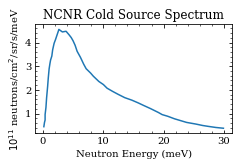

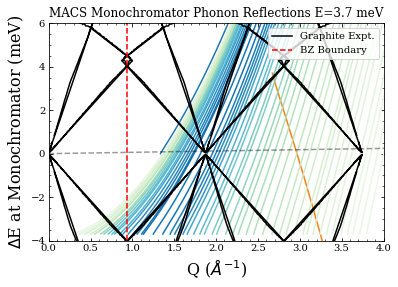

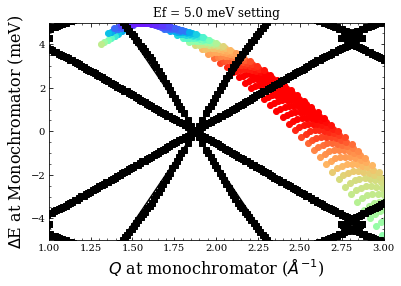

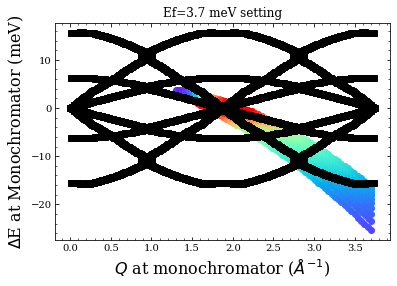

In [4]:
#Q is a linear walk from the gamma point to the A point

tau002 = 1.873
tauA = tau002/2.0
Q = np.linspace(0,3.0*tauA,500)
Ef = np.linspace(0,10,500)
lamf = 9.045 / np.sqrt(Ef)
Ei_set = 3.7
lami = 9.045 / np.sqrt(Ei_set)

#Import the cold source and dispersion relation
#source = np.genfromtxt('ncnr_coldsource_d2phi_dlambdadOmega.csv',delimiter=',')
source = np.genfromtxt('Coldsource.csv',delimiter=',')
graphite = np.genfromtxt('graphitedispersion2.csv',delimiter=',') #Format is Branch1 X, Branch1 Y, Branch2 X ...

#Get a callable interpolation for each of the four branches
branch1_interp = interpolate.interp1d(x=graphite[:,0],y=graphite[:,1])
branch2_interp = interpolate.interp1d(x=graphite[:,2],y=graphite[:,3])
branch3_interp = interpolate.interp1d(x=graphite[:,4],y=graphite[:,5])
branch4_interp = interpolate.interp1d(x=graphite[:,6],y=graphite[:,7])

#Normalize the cold source intensity
source_integral= np.trapz(x=source[:,0],y=source[:,1])
source[:,1]=source[:,1]/source_integral
#Get a spline
source_interp = interpolate.interp1d(x=source[:,0],y=source[:,1],fill_value='extrapolate')

fig,ax = plt.subplots(1,1,figsize=(3.54,2))
ax.plot(source[:,0],source[:,1]*source_integral)
ax.set_xlabel('Neutron Energy (meV)')
ax.set_ylabel('$10^{11}$ neutrons/cm$^2$/sr/s/meV')
ax.set_title('NCNR Cold Source Spectrum')
fig.savefig('ncnr_coldsource_fig.pdf')
#Get a density of wavelengths for incident neutrons
lams = 9.045 / np.sqrt(source[:,1])
Eis = 81.82/(lams**2)
lams = 9.045 / np.sqrt(3.7)

#Determine the twoTheta of the monochromator setting
twoTheta = 2.0*np.arcsin(tau002*lami/(4.0*np.pi))
print('TwoTheta='+str(twoTheta*180.0/np.pi))
kf = 2.0*np.pi/lamf
ki = 2.0*np.pi/lams
Q = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoTheta))
plt.figure()
plt.plot(Q,Ef)
#Do lam/2 reflection
Q = np.sqrt((ki*2.0)**2 + kf**2 - 2.0*(ki*2.0)*kf*np.cos(twoTheta))
plt.plot(Q,Ei_set - Ef)
plt.xlabel('Q ($\AA^{-1}$)',fontsize=16)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)

def getcolor(val,vmin,vmax,cmap):
    cmap = matplotlib.cm.get_cmap(cmap)
    norm_val = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    rgba = cmap(norm_val(val))
    return rgba
#Iterate through all possible source neutrons, plot lines like the ones above. 
#Their color will be determined by their neutron weight.
for i in range(len(source[:,1])):
    energy = source[i,0]
    weight = source[i,1]
    lam = 9.045/np.sqrt(energy)
    ki = 2.0*np.pi/lam
    Q = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoTheta))
    plt.plot(Q,Ef-Ei_set,color=getcolor(weight,0,0.1,'GnBu'))

#Overplot the disperion relationship of graphite
disp_marker=''
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')

plt.plot(np.ones(100)*tauA,np.linspace(-20,20,100),'r--',label='BZ Boundary')
plt.plot(np.linspace(0,6,100),'k--',alpha=0.4)
plt.legend(loc=1)
plt.title('MACS Monochromator Phonon Reflections E='+str(Ei_set)+' meV')
plt.xlim(0,4)
plt.ylim(-4,6)

#Write a function to determine for a given Ei, the weight of the allowed phonon branches and their overall cross section
def calc_graphite(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    twoTheta = 2.0*np.arcsin(tau002*lami_set/(4.0*np.pi))  

    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    Qmax = 3.7#np.sqrt(0.12**2 + kf**2 - 2.0*0.12*kf*np.cos(twoTheta)**2)
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei
    Q = np.linspace(Qmin+0.01,Qmax,60) #Allowed Q's based on kinematics
    kis = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    

    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.08,cmap='rainbow')
    for i in range(len(colors)):
        plt.plot(Q[i],Ef-Eis[i],c=colors[i],ls='-',marker='o')
    #Get a weighted phonon cross section for the 
    
        
        
plt.figure()
for Ei in np.linspace(5,8.0,10):
    calc_graphite(Ei,5.0)
plt.title('Ef = 5.0 meV setting')
#Overplot the disperion relationship of graphite

for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
plt.ylim(-5,5)
plt.xlim(1,3)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)
plt.xlabel('$Q$ at monochromator ($\AA^{-1}$)',fontsize=16) 
    
plt.figure()
for Ei in np.linspace(3.0,5.0,10):
    calc_graphite(Ei,3.7)
plt.title('Ef=3.7 meV setting')

#Overplot the disperion relationship of graphite
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
#plt.xlim(1,3)
#plt.ylim(-2,2)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)
plt.xlabel('$Q$ at monochromator ($\AA^{-1}$)', fontsize=16)

## Simple one phonon neutron cross section is given by (Squires):

$$\frac{d^2\sigma}{d\Omega dE}_{coh 1 ph} = \frac{2}{3}\frac{k'}{k_i}\frac{\sigma_{coh}}{4\pi M}e^{-2W}|F(\tau)|^2 \frac{Q^2}{\omega}$$

Assuming polarization terms sum to 2/3

So, for a given energy transfer we can integrate over the full allowed spectrum and find a lineshape that matches the experimentally observed one. We really only care about the negative transfer side.

In [5]:
def calc_graphite_num(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=5.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,1000) #Allowed Q's based on kinematics
    kis_minus = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

def calc_graphite_num_plus(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=3.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,1000) #Allowed Q's based on kinematics
    kis = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    #kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

def calc_graphite_num_minus(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=3.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,1000) #Allowed Q's based on kinematics
    #kis_minus = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

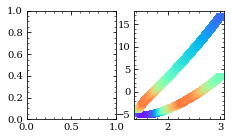

In [7]:

fig,ax=plt.subplots(1,2,figsize=(3.54,2))
fig.subplots_adjust(wspace=0.2)
out_arr_3p7=[]

Eis = np.arange(3.7,3.7+1.4,0.1)[::-1]
Eis = [3.7+0.2]
for Ei in Eis:
    Ef=3.7
    qout,deltaE,weights,colors = calc_graphite_num_plus(Ei,Ef)
    #for i in range(len(qout)):
        #out_arr_3p7.append([qout[i],deltaE[i],weights[i]])
    #Do this for the negative solution for ki as well.
    qout,deltaE,weights,colors = calc_graphite_num_minus(Ei,Ef)
    for i in range(len(qout)):
        out_arr_3p7.append([qout[i],deltaE[i],weights[i]])
        
out_mat_3p7 = np.array(out_arr_3p7)
out_mat_3p7 = out_mat_3p7[out_mat_3p7[:,0].argsort()]

out_arr_5p0 = []
Eis = np.arange(5.0,15.0,0.3)[::-1]
Eis = [6.0]
for Ei in Eis:
    Ef=5.0
    qout,deltaE,weights,colors = calc_graphite_num_plus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==5.0:
            ax[1].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[1].plot(qout[i],deltaE[i],color=colors[i],marker='s')
        #out_arr_5p0.append([qout[i],deltaE[i],weights[i]])

    #Do this for the negative solution for ki as well.
    qout,deltaE,weights,colors = calc_graphite_num_minus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==5.0:
            ax[1].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[1].plot(qout[i],deltaE[i],color=colors[i],marker='s')
        out_arr_5p0.append([qout[i],deltaE[i],weights[i]])
out_mat_5p0 = np.array(out_arr_5p0)
#Sort by Q 
out_mat_5p0 = out_mat_5p0[out_mat_5p0[:,0].argsort()]

0.08453410643933625


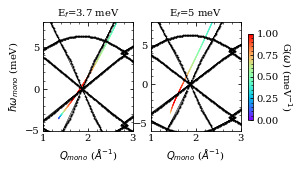

In [8]:
fig,ax=plt.subplots(1,2,figsize=(3.54,2))
fig.subplots_adjust(wspace=0.2)

vmin=0.0
vmax=np.nanmax(out_mat_3p7[:,2])
print(vmax)
cmap='rainbow'

#Make a color plot of the allowed scattering from the monochromator
ax[0].scatter(out_mat_3p7[:,0].flatten(),out_mat_3p7[:,1].flatten(),\
                  c=out_mat_3p7[:,2],s=1,cmap=cmap,vmin=vmin,vmax=vmax,edgecolor='none')

ax[1].scatter(out_mat_5p0[:,0].flatten(),out_mat_5p0[:,1].flatten(),\
                  c=out_mat_5p0[:,2].flatten(),s=1,cmap=cmap,vmin=vmin,vmax=vmax,edgecolor='none')
ax[0].set_xlim(1,3.0)
ax[0].set_ylim(-5,8)
#Overplot the disperion relationship of graphite
ax[1].set_xlim(1,3.0)
ax[1].set_ylim(-6,8)
ax[0].set_title('E$_f$=3.7 meV',fontsize=10)
ax[0].set_ylabel('$\hbar\omega_{mono}$ (meV)')
ax[1].set_title('E$_f$=5 meV',fontsize=10)
#ax[1].set_ylabel('$\hbar\omega_{mono}$ (meV)',fontsize=10)
ax[1].set_xlabel('$Q_{mono}$ ($\AA^{-1}$)', fontsize=10)        
ax[0].set_xlabel('$Q_{mono}$ ($\AA^{-1}$)', fontsize=10)        

#plot the elastic scattering condition. 
qel,deltaE5,weights5,colors5 = calc_graphite_num_plus(5.0,5.0)
#ax[1].plot(qel,deltaE5,'r-',lw=1)
qel,deltaE5,weights5,colors5 = calc_graphite_num_minus(5.0,5.0)
#ax[1].plot(qel,deltaE5,'r-',lw=1)

qel3,deltaE3,weights3,colors3= calc_graphite_num_plus(3.7,3.7)
#ax[0].plot(qel3,deltaE3,'r-',lw=1)
qel3,deltaE3,weights3,colors3 = calc_graphite_num_minus(3.7,3.7)
#ax[0].plot(qel3,deltaE3,'r-',lw=1)

phonon_marker='^'
lw=0.5
ms=1
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',label='Graphite Expt.',lw=lw,ms=ms)
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',label='Graphite Expt.',lw=lw,ms=ms)
    else:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)

    #Repeat this four times to accomodate the relevant range of Q space
    ax[0].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[0].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[0].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)

    else:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    #Repeat this four times to accomodate the relevant range of Q space
    ax[0].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[0].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[0].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    ax[1].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-',lw=lw,ms=ms)
    
#Add a colorbar 
cbar_ax = fig.add_axes([0.93,0.2,0.02,0.6])
cbar_ax.tick_params(labelleft=False,labelright=True,labelbottom=False,labeltop=False)
cbar_ax.tick_params(labelsize=10)
cmap=plt.get_cmap(cmap)
norm=matplotlib.colors.Normalize(vmin=0,vmax=1)
cbar_ax.text(7.45,0.5,'G($\omega$) (meV$^{-1}$)',rotation=-90,fontsize=10,transform=cbar_ax.transAxes,\
            verticalalignment='center',horizontalalignment='center')
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cb = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=cmap,norm=norm,orientation='vertical')
fig.savefig('MACS_mono_plot.pdf',bbox_inches='tight',dpi=300)
fig.savefig('MACS_mono_plot.png',bbox_inches='tight',dpi=300)
plt.show()

(-4.0, 5.0)

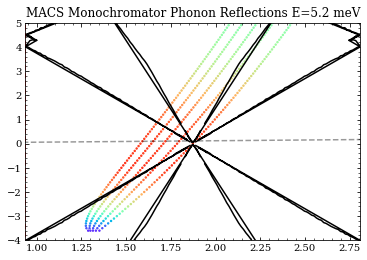

In [9]:
import scipy
import copy
# Quantify this effect as a function of energy transfer setting
plt.figure()

tau002 = 1.873
tauA = tau002/2.0

def calcQmono(Es,Ef,twoThetaMono):
    lamf = np.sqrt(81.81/Ef)
    lams = np.sqrt(81.81/Es)
    kf = 2.0*np.pi/lamf
    ks = 2.0*np.pi/lams
    Qmono = np.sqrt(ks**2 + kf**2 - 2.0*ks*kf*np.cos(twoThetaMono))
    weights = source_interp(x=Es)
    omega_mono = Es-Ef
    return Qmono,omega_mono,weights


#Start with Ef = 3.7 
Ef = 3.7 
Eis = np.linspace(3.7,3.7+1.5,5)
#Eis = [4.5]
for Ei_set in Eis:
    lamf = np.sqrt(81.81/Ei_set)
    ki_set = 2.0*np.pi/lamf
    omega_set = Ei_set - Ef
    #Iterate through the source intensity energies, 
    #Calculate Qmono for each that satisfies twoTheta    condition
    twoThetaEf3p7 = np.arccos((ki_set**2 + ki_set**2 - tau002**2)/(2.0*ki_set**2))


    energies = np.linspace(0.1,30.0,300)
    q_3p7,omega_3p7,weights_3p7 = calcQmono(energies,Ef,twoThetaEf3p7)
    plt.scatter(q_3p7,omega_3p7,c=weights_3p7,vmin=0,vmax=0.09,cmap='rainbow',s=2)
#Overplot the disperion relationship of graphite
disp_marker=''
phonon_keys = ['1','2','3','4']
interp_dict = {}
for i in [0,1,2,3]:
    branchX_tot = []
    branchY_tot = []
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this three times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this three times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    #make an interpolator object to find intercept
    branchX_tot = [graphite[:,2*i],-1.0*branchX+2.0*tauA,branchX+2.0*tauA,-1.0*branchX+4.0*tauA]
    branchY_tot = [graphite[:,2*i +1],graphite[:,2*i +1],graphite[:,2*i +1],graphite[:,2*i +1]]
    branchX_tot = np.array(branchX_tot).flatten()
    branchY_tot = np.array(branchY_tot).flatten()
    interp_branch = scipy.interpolate.interp1d(x=np.array(branchX_tot),y=np.array(branchY_tot))
    interp_dict[phonon_keys[i]]=copy.copy(interp_branch)

plt.plot(np.ones(100)*tauA,np.linspace(-20,20,100),'r--',label='BZ Boundary')
plt.plot(np.linspace(0,6,100),'k--',alpha=0.4)
plt.title('MACS Monochromator Phonon Reflections E='+str(Ei_set)+' meV')
plt.xlim(tauA,tauA*3)
plt.ylim(-4,5)

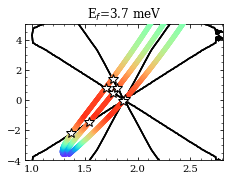

In [10]:
def interpolated_intercepts(x, y1, y2):
    """Find the intercepts of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idxs = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)

    xcs = []
    ycs = []

    for idx in idxs:
        xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
        xcs.append(xc)
        ycs.append(yc)
    return np.array(xcs), np.array(ycs)


clist = ['k','r','g','b']
Eis= [4.5]
Eis3 = [3.7,4.4,5.0]
#Eis3 = np.arange(3.7,5.0,0.1)
Bw_list = []
#Output will be a matrix with rows of the following form:
#[Eiset,B]
fig,ax=plt.subplots(1,1,figsize=(3.54,2.5))

phonon_keys=['1','2','3']

for Ei_set in Eis3:
    B_Ei = 0.0
    for i in range(len(phonon_keys)):
        qlist = np.linspace(1,3,500)
        phonons = interp_dict[phonon_keys[i]](x=qlist)
        phonons2 = -phonons
        ax.plot(qlist,phonons,color='k',zorder=3)
        ax.plot(qlist,phonons2,color='k',zorder=2)
        #Calculate allowed monochromator scattering for some Ei
        #Start with Ef = 3.7 
        Ef = 3.7 
        #Eis = np.linspace(3.7,3.7+1.5,5)
        lamf = np.sqrt(81.81/Ei_set)
        ki_set = 2.0*np.pi/lamf
        omega_set = Ei_set - Ef
        #Iterate through the source intensity energies, 
        #Calculate Qmono for each that satisfies twoTheta    condition
        twoThetaEf3p7 = np.arccos((ki_set**2 + ki_set**2 - tau002**2)/(2.0*ki_set**2))
        energies = np.linspace(0.1,30.0,500)
        q_3p7,omega_3p7,weights_3p7 = calcQmono(energies,Ef,twoThetaEf3p7)
        ax.scatter(q_3p7,omega_3p7,c=weights_3p7,vmin=0,vmax=0.09,cmap='rainbow',s=4,zorder=5,ls='-',lw=3)
        #Make an interpolator of the same dimension as phonons
        interp_mono = scipy.interpolate.interp1d(x=q_3p7,y=omega_3p7,bounds_error=False,fill_value=100.0)
        interp_weights = scipy.interpolate.interp1d(x=q_3p7,y=weights_3p7,bounds_error=False,fill_value=100.0)

        y2 = interp_mono(x=qlist)
        y1 = phonons
        #Find the closest values
        # new method!
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot=0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                ax.plot(xc, yc,marker='*',color='k',mec='k',mfc='w', ms=10, \
                        label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                B_pt = Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        #Repeat for minus values
        # new method!
        y1=-1.0*y1
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot = 0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                ax.plot(xc, yc,marker='*',color='k',mec='k',mfc='w',\
                        ms=10, label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                bose = np.exp(-Omegapt/(8.62e-2 * 290.0))

                B_pt = bose*Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        
    Bw_list.append(B_Ei)
ax.set_xlim(tauA,tauA*3)
ax.set_ylim(-4,5)

#Add annotations for lines of different energy settings
ax.set_title('E$_f$=3.7 meV')

fig.savefig('monochromator_paths_ef3p7.pdf',bbox_inches='tight')


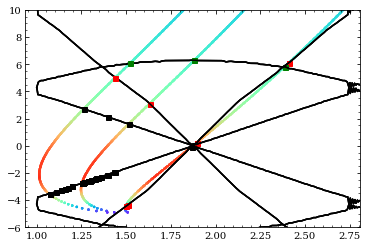

In [12]:
clist = ['k','r','g','b']
Eis= [4.5]
Eis5 = [5.0,9.0,15.0]
#Eis5 = np.arange(5.0,15.0,0.5)
Bw_list5 = []
#Output will be a matrix with rows of the following form:
#[Eiset,B]
plt.figure()
phonon_keys=['1','2','3','4']
for Ei_set in Eis5:
    B_Ei = 0.0
    for i in range(len(phonon_keys)):
        qlist = np.linspace(1,3,1000)
        phonons = interp_dict[phonon_keys[i]](x=qlist)
        phonons2 = -phonons
        plt.plot(qlist,phonons,color='k')
        plt.plot(qlist,phonons2,color='k')
        #Calculate allowed monochromator scattering for some Ei
        #Start with Ef = 5.0
        Ef = 5.0
        #Eis = np.linspace(3.7,3.7+1.5,5)
        lamf = np.sqrt(81.81/Ei_set)
        ki_set = 2.0*np.pi/lamf
        omega_set = Ei_set - Ef
        #Iterate through the source intensity energies, 
        #Calculate Qmono for each that satisfies twoTheta    condition
        twoThetaEf3p7 = np.arccos((ki_set**2 + ki_set**2 - tau002**2)/(2.0*ki_set**2))
        energies = np.linspace(0.1,30.0,300)
        q_3p7,omega_3p7,weights_3p7 = calcQmono(energies,Ef,twoThetaEf3p7)
        plt.scatter(q_3p7,omega_3p7,c=weights_3p7,vmin=0,vmax=0.09,cmap='rainbow',s=2)
        #Make an interpolator of the same dimension as phonons
        interp_mono = scipy.interpolate.interp1d(x=q_3p7,y=omega_3p7,bounds_error=False,fill_value=100.0)
        interp_weights = scipy.interpolate.interp1d(x=q_3p7,y=weights_3p7,bounds_error=False,fill_value=100.0)

        y2 = interp_mono(x=qlist)
        y1 = phonons
        #Find the closest values
        # new method!
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot=0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                plt.plot(xc, yc,marker='s',color=clist[i], ms=5, label='Nearest data-point, with linear interpolation')
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                B_pt = Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        #Repeat for minus values
        # new method!
        y1=-1.0*y1
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot = 0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                plt.plot(xc, yc,marker='s',color=clist[i], ms=5, label='Nearest data-point, with linear interpolation')
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                #Also need Bose-Einstein factor for negative transfers. 
                bose = np.exp(-Omegapt/(8.62e-2 * 290.0))
                B_pt = bose*Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
    Bw_list5.append(B_Ei)
    plt.xlim(tauA,tauA*3)
    plt.ylim(-6,10)


In [14]:
np.exp(-15.0/(8.62e-2 * 280.0))

0.5371497873841682

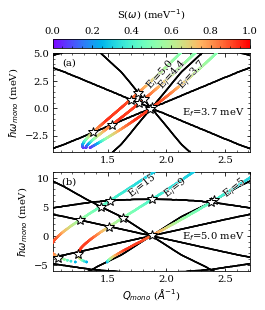

In [53]:
fig,ax=plt.subplots(2,1,figsize=(3.54,4.0))
fig.subplots_adjust(hspace=0.2,wspace=0.3)
phonon_keys=['1','2','3','4']

msize=2
lw=1

for Ei_set in Eis3:
    B_Ei = 0.0
    for i in range(len(phonon_keys)):
        qlist = np.linspace(1,3,500)
        phonons = interp_dict[phonon_keys[i]](x=qlist)
        phonons2 = -phonons
        ax[0].plot(qlist,phonons,color='k',zorder=3)
        ax[0].plot(qlist,phonons2,color='k',zorder=2)
        #Calculate allowed monochromator scattering for some Ei
        #Start with Ef = 3.7 
        Ef = 3.7 
        #Eis = np.linspace(3.7,3.7+1.5,5)
        lamf = np.sqrt(81.81/Ei_set)
        ki_set = 2.0*np.pi/lamf
        omega_set = Ei_set - Ef
        #Iterate through the source intensity energies, 
        #Calculate Qmono for each that satisfies twoTheta    condition
        twoThetaEf3p7 = np.arccos((ki_set**2 + ki_set**2 - tau002**2)/(2.0*ki_set**2))
        energies = np.linspace(0.1,30.0,500)
        q_3p7,omega_3p7,weights_3p7 = calcQmono(energies,Ef,twoThetaEf3p7)
        ax[0].scatter(q_3p7,omega_3p7,c=weights_3p7,vmin=0,vmax=0.09,cmap='rainbow',s=msize,zorder=5,ls='-',lw=lw)
        #Make an interpolator of the same dimension as phonons
        interp_mono = scipy.interpolate.interp1d(x=q_3p7,y=omega_3p7,bounds_error=False,fill_value=100.0)
        interp_weights = scipy.interpolate.interp1d(x=q_3p7,y=weights_3p7,bounds_error=False,fill_value=100.0)

        y2 = interp_mono(x=qlist)
        y1 = phonons
        #Find the closest values
        # new method!
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot=0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                ax[0].plot(xc, yc,marker='*',color='k',mec='k',mfc='w', ms=10, \
                        label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                B_pt = Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        #Repeat for minus values
        # new method!
        y1=-1.0*y1
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot = 0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                ax[0].plot(xc, yc,marker='*',color='k',mec='k',mfc='w',\
                        ms=10, label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                bose = np.exp(-Omegapt/(8.62e-2 * 290.0))

                B_pt = bose*Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        
    Bw_list.append(B_Ei)
ax[0].set_xlim(tauA,tauA*3)
ax[0].set_ylim(-4,5)

#Now the Ef=5 meV
phonon_keys=['1','2','3','4']
for Ei_set in Eis5:
    B_Ei = 0.0
    for i in range(len(phonon_keys)):
        qlist = np.linspace(1,3,200)
        phonons = interp_dict[phonon_keys[i]](x=qlist)
        phonons2 = -phonons
        ax[1].plot(qlist,phonons,color='k')
        ax[1].plot(qlist,phonons2,color='k')
        #Calculate allowed monochromator scattering for some Ei
        #Start with Ef = 5.0
        Ef = 5.0
        #Eis = np.linspace(3.7,3.7+1.5,5)
        lamf = np.sqrt(81.81/Ei_set)
        ki_set = 2.0*np.pi/lamf
        omega_set = Ei_set - Ef
        #Iterate through the source intensity energies, 
        #Calculate Qmono for each that satisfies twoTheta    condition
        twoThetaEf3p7 = np.arccos((ki_set**2 + ki_set**2 - tau002**2)/(2.0*ki_set**2))
        energies = np.linspace(0.5,30.0,200)
        q_3p7,omega_3p7,weights_3p7 = calcQmono(energies,Ef,twoThetaEf3p7)
        ax[1].scatter(q_3p7,omega_3p7,c=weights_3p7,vmin=0,vmax=0.09,cmap='rainbow',s=msize,zorder=5,ls='-',lw=lw)
        #Make an interpolator of the same dimension as phonons
        interp_mono = scipy.interpolate.interp1d(x=q_3p7,y=omega_3p7,bounds_error=False,fill_value=100.0)
        interp_weights = scipy.interpolate.interp1d(x=q_3p7,y=weights_3p7,bounds_error=False,fill_value=100.0)

        y2 = interp_mono(x=qlist)
        y1 = phonons
        #Find the closest values
        # new method!
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot=0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<0.1:
                ax[1].plot(xc, yc,marker='*',color='k',mec='k',mfc='w',\
                        ms=10, label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                B_pt = Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        #Repeat for minus values
        # new method!
        y1=-1.0*y1
        xcs, ycs = interpolated_intercepts(qlist,y1,y2)
        #Check for strange intercepts
        qcs=[]
        omegacs=[]
        B_tot = 0.0
        for xc, yc in zip(xcs, ycs):
            closest_i = np.argmin(np.abs(xc-qlist))
            if np.abs(interp_mono(x=xc)-yc)<1:
                # The function fails for some reason, need to do these manually.
                #ax[1].plot(xc, yc,marker='*',color='k',mec='k',mfc='w',\
                        #ms=10, label='Nearest data-point, with linear interpolation',zorder=10)
                qcs.append(xc)
                omegacs.append(yc)
                #Finally, get an overall weighting factor for this. 
                Qpt = xc
                Omegapt = yc 
                Ks_weight_pt = interp_weights(x=Qpt)
                bose = np.exp(-Omegapt/(8.62e-2 * 290.0))

                B_pt = bose*Ks_weight_pt*Qpt**2/np.abs(Omegapt)
                B_tot+=B_pt
        B_Ei+=B_tot
        B_Ei+=B_tot
    Bw_list5.append(B_Ei)
    plt.xlim(tauA,tauA*3)
    plt.ylim(-6,10)


#Manually add a few intersections that the function did not find. 
pts=[[1.08,-3.8],[1.25,-3.1]]
for pt in pts:
    xc,yc=pt
    ax[1].plot(xc, yc,marker='*',color='k',mec='k',mfc='w',ms=10, label='Nearest data-point, with linear interpolation',zorder=10)    
#Add annotations for lines of different energy settings
ax[0].set_title('')
ax[1].set_title('')
txta=ax[0].text(0.46,0.65,'E$_i$='+f"{Eis3[2]:.1f}",rotation=48,transform=ax[0].transAxes,color='k',zorder=40)
txtb=ax[0].text(0.52,0.65,'E$_i$='+f"{Eis3[1]:.1f}",rotation=48,transform=ax[0].transAxes,color='k',zorder=40)
txtc=ax[0].text(0.62,0.65,'E$_i$='+f"{Eis3[0]:.1f}",rotation=48,transform=ax[0].transAxes,color='k',zorder=40)

txt1=ax[1].text(0.37,0.75,'E$_i$='+f"{Eis5[2]:.0f}",rotation=38,transform=ax[1].transAxes,color='k',zorder=40)
txt2=ax[1].text(0.55,0.75,'E$_i$='+f"{Eis5[1]:.0f}",rotation=38,transform=ax[1].transAxes,color='k',zorder=40)
txt3=ax[1].text(0.85,0.75,'E$_i$='+f"{Eis5[0]:.0f}",rotation=38,transform=ax[1].transAxes,color='k',zorder=40)

for txt in [txta,txtb,txtc,txt1,txt2,txt3]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=1,foreground='w')])


txt_a=ax[0].text(0.05,0.95,'(a)',color='k',transform=ax[0].transAxes,horizontalalignment='left',\
          verticalalignment='top')
txt_b=ax[1].text(0.05,0.95,'(b) ',color='k',transform=ax[1].transAxes,horizontalalignment='left',\
          verticalalignment='top')
txt_a2=ax[0].text(0.97,0.4,'E$_f$=3.7 meV',color='k',transform=ax[0].transAxes,horizontalalignment='right',\
          verticalalignment='center')
txt_b2=ax[1].text(0.97,0.35,'E$_f$=5.0 meV ',color='k',transform=ax[1].transAxes,horizontalalignment='right',\
          verticalalignment='center')

ax[0].set_ylabel('$\hbar\omega_{mono}$ (meV)')
ax[1].set_ylabel('$\hbar\omega_{mono}$ (meV)')
ax[1].set_xlabel('$Q_{mono}$ ($\AA^{-1}$)')
ax[0].set_xlim(1.1*tauA,2.9*tauA)
ax[1].set_xlim(1.1*tauA,2.9*tauA)   
ax[1].set_ylim(-6,11)
#Finally, add colorbars to each. 
cbar_ax = fig.add_axes([0.125,0.9,0.775,0.03])
cbar_ax.tick_params(labelsize=10)
cmap=plt.get_cmap('rainbow')
norm=matplotlib.colors.Normalize(vmin=0,vmax=1)
cbar_ax.text(0.5,3,'S($\omega$) (meV$^{-1}$)',rotation=-0,fontsize=10,transform=cbar_ax.transAxes,\
            verticalalignment='bottom',horizontalalignment='center')
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cb = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=cmap,norm=norm,orientation='horizontal')
cbar_ax.tick_params(labelleft=False,labelright=True,labelbottom=False,labeltop=True)

fig.savefig('monochromator_paths.pdf',bbox_inches='tight')
fig.savefig('monochromator_paths.png',bbox_inches='tight',dpi=300)


In [16]:
tauA

0.9365